In [1]:
import SimpleITK as sitk
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import re
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from mish_activation import *
import torchvision.models

In [2]:
LABELS = '../input/osic-pulmonary-fibrosis-progression/train.csv'
DATA = '../input/osic-pulmonary-fibrosis-progression/test.csv'
PATH = '../input/osic-pulmonary-fibrosis-progression/test/'
MODELS1 = [f'../input/osic-models/model3c_{i}.pth' for i in range(4)] + \
         [f'../input/osic-models/model5c_feature_{i}.pth' for i in range(4)]
MODELS2 = [f'../input/osic-models/model0c_{i}.pth' for i in range(4)]
NUM_WORKERS = 2
sz = 224
r1,r2 = -12,134
Nmax = 256#384#256
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
df0 = pd.read_csv(LABELS)
df0['Percent'] = df0['Percent']/100.0
df0['V0'] = df0['FVC']/df0['Percent']
df0 = df0.groupby('Patient')[['Weeks','FVC','Percent']].agg(list).\
       join(df0.groupby('Patient')[['Age','Sex','SmokingStatus','V0']].max())
df0 = df0.reset_index()
smoke_map = {'Ex-smoker':0, 'Never smoked':1, 'Currently smokes':2}
sex_map = {'Male':0, 'Female':1}
df0['smoke_feature'] = df0.SmokingStatus.map(smoke_map)
df0['sex_feature'] = df0.Sex.map(sex_map)
df0['age_feature'] = (df0['Age'] - df0['Age'].mean())/df0['Age'].std()

df = pd.read_csv(DATA)
df['Percent'] = df['Percent']/100.0
df['V0'] = df['FVC']/df['Percent']
df['smoke_feature'] = df.SmokingStatus.map(smoke_map)
df['sex_feature'] = df.Sex.map(sex_map)
df['age_feature'] = (df['Age'] - df0['Age'].mean())/df0['Age'].std()
df.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,V0,smoke_feature,sex_feature,age_feature
0,ID00419637202311204720264,6,3020,0.701869,73,Male,Ex-smoker,4302.8,0,0,0.809626
1,ID00421637202311550012437,15,2739,0.820453,68,Male,Ex-smoker,3338.4,0,0,0.104209
2,ID00422637202311677017371,6,1930,0.766725,73,Male,Ex-smoker,2517.2,0,0,0.809626
3,ID00423637202312137826377,17,3294,0.792589,72,Male,Ex-smoker,4156.0,0,0,0.668543
4,ID00426637202313170790466,0,2925,0.718250,73,Male,Never smoked,4072.4,1,0,0.809626


In [4]:
mean = torch.Tensor([0.3428277166956346])
std = torch.Tensor([0.3143923981299627])

def img2tensor(img,dtype:np.dtype=np.float32):
    if img.ndim==2 : img = np.expand_dims(img,2)
    img = np.transpose(img,(2,0,1))
    return torch.from_numpy(img.astype(dtype, copy=False))

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

class OSICDataset(Dataset):
    def __init__(self, path):
        self.path = path
        self.names = []
        for pi in os.listdir(path):
            try:
                image = sitk.ReadImage(os.path.join(path,pi))
                inimg_raw = sitk.GetArrayFromImage(image)
                self.names.append(pi)
            except Exception as e:
                print('corrupted image:',os.path.join(path,pi))
        self.names.sort(key=natural_keys)
        l = len(self.names)
        self.names = self.names[int(0.1*l):int(0.9*l)] #remove images without lungs
        l = len(self.names)
        self.names = self.names[(l//2-min(Nmax,l)//2):(l//2+min(Nmax,l)//2)]

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        pi = self.names[idx]
        image = sitk.ReadImage(os.path.join(self.path,pi))
        inimg_raw = sitk.GetArrayFromImage(image)
        s = min(inimg_raw.shape[1:])
        inimg_raw = inimg_raw[(inimg_raw.shape[0]//2-s//2):(inimg_raw.shape[0]//2+s//2),
                              (inimg_raw.shape[1]//2-s//2):(inimg_raw.shape[1]//2+s//2)]
        del image

        #while inimg_raw.mean() < -1024: inimg_raw += 1024
        while inimg_raw.mean() < -1150 and inimg_raw.max() < 3000: inimg_raw += 1024
        inimg_raw[inimg_raw > 600] = 600
        inimg_raw[inimg_raw < -1024] = -1024
        inimg_raw = ((inimg_raw + 1024)/1624)[0]
        if inimg_raw.shape[-1] != sz: inimg_raw = cv2.resize(inimg_raw, (sz, sz), interpolation=cv2.INTER_AREA)
        
        img = (img2tensor(inimg_raw) - mean)/std
        return img

In [5]:
from torchvision.models.resnet import ResNet, Bottleneck

def AdaptiveConcatMaskPool2d(x,m,output_size=1):
    result = []
    for xi,mi in zip(x,m):
        xi = xi[:mi].unsqueeze(0)
        shape = xi.shape
        xi = xi.permute(0,2,1,3,4).contiguous().view(-1,shape[2],shape[3]*mi,shape[4])
        result.append(torch.cat([F.adaptive_max_pool2d(xi,output_size),
                                 F.adaptive_avg_pool2d(xi,output_size)],1))
    return torch.cat(result, 0)

class Model1(nn.Module):
    def __init__(self, arch='resnext50_32x4d_ssl', n=4, pre=True, ps=0.5):
        super().__init__()
        m = ResNet(Bottleneck, [3, 4, 6, 3], groups=32, width_per_group=4)
        nc = list(m.children())[-1].in_features
        
        self.enc = nn.Sequential(*list(m.children())[:-2])
        shape = self.enc[0].weight.shape
        w = self.enc[0].weight.sum(1).unsqueeze(1)
        self.enc[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.enc[0].weight = nn.Parameter(w)
        self.head = nn.Sequential(nn.Linear(2*nc+9,512),Mish(),nn.GroupNorm(32,512),
                                  nn.Dropout(ps),nn.Linear(512,n))
        self.emb_sm,self.emb_sx = nn.Embedding(3,4),nn.Embedding(2,4)
        
    def forward(self, x, m, smf, sxf, af):
        shape = x.shape
        n = shape[1]
        x = x.view(-1,shape[2],shape[3],shape[4])
        x = self.enc(x)
        
        shape = x.shape
        x = AdaptiveConcatMaskPool2d(x.view(-1,n,shape[1],shape[2],shape[3]),m)
        x = torch.cat([x.view(x.size(0), -1),self.emb_sm(smf),self.emb_sx(sxf),af.unsqueeze(-1)],1)
        x = self.head(x)
        return x

class Model2(nn.Module):
    def __init__(self, n=4, ps=0.5):
        super().__init__()
        m = torchvision.models.resnet18()
        nc = list(m.children())[-1].in_features
        
        self.enc = nn.Sequential(*list(m.children())[:-2])
        shape = self.enc[0].weight.shape
        w = self.enc[0].weight.sum(1).unsqueeze(1)
        self.enc[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.enc[0].weight = nn.Parameter(w)
        self.head = nn.Sequential(nn.Linear(2*nc+9,512),Mish(),nn.GroupNorm(32,512),
                                  nn.Dropout(ps),nn.Linear(512,n))
        self.emb_sm,self.emb_sx = nn.Embedding(3,4),nn.Embedding(2,4)
        
    def forward(self, x, m, smf, sxf, af):
        shape = x.shape
        n = shape[1]
        x = x.view(-1,shape[2],shape[3],shape[4])
        x = self.enc(x)
        
        shape = x.shape
        x = AdaptiveConcatMaskPool2d(x.view(-1,n,shape[1],shape[2],shape[3]),m)
        x = torch.cat([x.view(x.size(0), -1),self.emb_sm(smf),self.emb_sx(sxf),af.unsqueeze(-1)],1)
        x = self.head(x)
        return x

In [6]:
models = []
for path in MODELS1:
    state_dict = torch.load(path,map_location=torch.device('cpu'))
    model = Model1()
    model.load_state_dict(state_dict)
    model.float()
    model.eval()
    model.to(device)
    models.append(model)

for path in MODELS2:
    state_dict = torch.load(path,map_location=torch.device('cpu'))
    model = Model2()
    model.load_state_dict(state_dict)
    model.float()
    model.eval()
    model.to(device)
    models.append(model)
    
del state_dict

In [7]:
Patient_Week,FVC,Confidence = [],[],[]
for idx in range(len(df)):
    idx,pt,w,v0,smf,sxf,af = df.iloc[idx][['Patient','Percent','Weeks','V0','smoke_feature',
                                                  'sex_feature','age_feature']]
    ds = OSICDataset(os.path.join(PATH,idx))
    dl = DataLoader(ds,Nmax,num_workers=NUM_WORKERS,shuffle=False)
    x = next(iter(dl)).unsqueeze(0).to(device)
    smf,sxf,af = torch.LongTensor([smf]).to(device),torch.LongTensor([sxf]).to(device),torch.Tensor([af]).to(device)
    #print(x.shape[1])
    nm = torch.LongTensor([x.shape[1]]).to(device)
    
    with torch.no_grad():
        p = [m(x,nm,smf,sxf,af) for m in models]
    p = torch.cat(p,0).mean(0).cpu()
    
    for i in range(r1,r2):
        vp = v0*(p[0] + p[1]*i/132.0 + 100.0*pt - p[1]*w/132.0)/100.0
        sp = v0*F.softplus(p[2] + p[3]*i/132.0)
        Patient_Week.append(idx+'_'+str(i))
        FVC.append(vp.item())
        Confidence.append(sp.item())

In [8]:
df1 = pd.DataFrame({'Patient_Week':Patient_Week,'FVC':FVC,'Confidence':Confidence})
df1.to_csv('submission1.csv', index=False)
df1.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2951.215576,367.666565
1,ID00419637202311204720264_-11,2949.578125,367.859619
2,ID00419637202311204720264_-10,2947.940918,368.052734
3,ID00419637202311204720264_-9,2946.303467,368.245941
4,ID00419637202311204720264_-8,2944.666016,368.439362


In [9]:
import numpy as np
import pandas as pd
import os
import re
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from mish_activation import *

In [10]:
LABELS = '../input/osic-pulmonary-fibrosis-progression/train.csv'
DATA = '../input/osic-pulmonary-fibrosis-progression/test.csv'
PATH = '../input/osic-pulmonary-fibrosis-progression/test/'
MODELS1 =[f'../input/osic-tabular-models/model0c_{i}.pth' for i in range(4)] + \
         [f'../input/osic-tabular-models/model1c_{i}.pth' for i in range(4)] + \
         [f'../input/osic-tabular-models/model2c_{i}.pth' for i in range(4)] + \
         [f'../input/osic-tabular-models/model3c_{i}.pth' for i in range(4)] + \
         [f'../input/osic-tabular-models/model4c_{i}.pth' for i in range(4)]

MODELS2 =[f'../input/osic-tabular-models/model5c_{i}.pth' for i in range(1,5)] + \
         [f'../input/osic-tabular-models/model6c_{i}.pth' for i in range(4)] + \
         [f'../input/osic-tabular-models/model7c_{i}.pth' for i in range(4)] + \
         [f'../input/osic-tabular-models/model8c_{i}.pth' for i in range(4)] + \
         [f'../input/osic-tabular-models/model9c_{i}.pth' for i in range(4)]

MODELS3 =[f'../input/osic-tabular-models/model10c_{i}.pth' for i in range(4)] + \
         [f'../input/osic-tabular-models/model11c_{i}.pth' for i in range(4)] + \
         [f'../input/osic-tabular-models/model12c_{i}.pth' for i in range(4)] + \
         [f'../input/osic-tabular-models/model13c_{i}.pth' for i in range(4)] + \
         [f'../input/osic-tabular-models/model14c_{i}.pth' for i in range(4)]

NUM_WORKERS = 1
weeks = list(range(-12,134))
Np = len(weeks)
device = torch.device('cpu')

In [11]:
df0 = pd.read_csv(LABELS)
df0['Percent'] = df0['Percent']/100.0
df0['V0'] = df0['FVC']/df0['Percent']
df0 = df0.groupby('Patient')[['Weeks','FVC','Percent']].agg(list).\
       join(df0.groupby('Patient')[['Age','Sex','SmokingStatus','V0']].max())
df0 = df0.reset_index()
first,first_w = [],[]
for index, row in df0.iterrows():
    v = row['FVC'][0]
    first.append(float(v))
df0['first'] = first

df = pd.read_csv(DATA)
df['Percent'] = df['Percent']/100.0
df['V0'] = df['FVC']/df['Percent']
df['Weeks_feature'] = df['Weeks']/134
df = df.groupby('Patient')[['Weeks','FVC','Percent','Weeks_feature']].agg(list).\
       join(df.groupby('Patient')[['Age','Sex','SmokingStatus','V0']].max())
df = df.reset_index()
first,first_w = [],[]
for index, row in df.iterrows():
    v = row['FVC'][0]
    first.append(float(v))
    first_w.append(float(row['Weeks_feature'][0]))
df['first'] = first
df['first_w'] = first_w

df['Age_feature'] = ((df['Age'] - df0['Age'].mean())/df0['Age'].std()).astype(np.float)
df['first_feature'] = (df['first'] - df0['first'].mean())/df0['first'].std()
df['V0_feature'] = (df['V0'] - df0['V0'].mean())/df0['V0'].std()
df['Male'] = (df['Sex'] == 'Male').astype(np.int)
df['Female'] = (df['Sex'] == 'Female').astype(np.int)
df['Ex-smoker'] = (df['SmokingStatus'] == 'Ex-smoker').astype(np.int)
df['Never smoked'] = (df['SmokingStatus'] == 'Never smoked').astype(np.int)
df['Currently smokes'] = (df['SmokingStatus'] == 'Currently smokes').astype(np.int)

df.head()

,Patient,Weeks,FVC,Percent,Weeks_feature,Age,Sex,SmokingStatus,V0,first,first_w,Age_feature,first_feature,V0_feature,Male,Female,Ex-smoker,Never smoked,Currently smokes
0,ID00419637202311204720264,[6],[3020],[0.7018685507111652],[0.04477611940298507],73,Male,Ex-smoker,4302.8,3020.0,0.044776,0.809626,0.297108,1.093480,1,0,1,0,0
1,ID00421637202311550012437,[15],[2739],[0.820452911574407],[0.11194029850746269],68,Male,Ex-smoker,3338.4,2739.0,0.111940,0.104209,-0.039188,-0.201816,1,0,1,0,0
2,ID00422637202311677017371,[6],[1930],[0.766724932464643],[0.04477611940298507],73,Male,Ex-smoker,2517.2,1930.0,0.044776,0.809626,-1.007384,-1.304778,1,0,1,0,0
3,ID00423637202312137826377,[17],[3294],[0.792589027911453],[0.12686567164179105],72,Male,Ex-smoker,4156.0,3294.0,0.126866,0.668543,0.625026,0.896311,1,0,1,0,0
4,ID00426637202313170790466,[0],[2925],[0.71824968077792],[0.0],73,Male,Never smoked,4072.4,2925.0,0.000000,0.809626,0.183414,0.784027,1,0,0,1,0


In [12]:
features = ['Age_feature','Male','Female','Ex-smoker','Never smoked','Currently smokes',
            'V0_feature','first_feature','first_w']

def expand_list(l, n, pad=0):
    if len(l) >= n: del l[n:]
    else: l.extend([pad] * (n - len(l)))

class OSICDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x = self.df.iloc[idx][features].values
        idx,w = self.df.iloc[idx][['Patient','Weeks']]
        return (torch.Tensor(x.astype(np.float)),torch.Tensor([(wi - w[0])/134.0 for wi in weeks])), idx

In [13]:
def batchnorm_1d(nf:int, norm_type=1):
    bn = nn.BatchNorm1d(nf)
    with torch.no_grad():
        bn.bias.fill_(1e-3)
        bn.weight.fill_(0.0 if norm_type==0 else 1.0)
    return bn

class LinearBlock(nn.Module):
    def __init__ (self, in_sz, out_sz, activation=nn.ReLU(inplace=True), ps=None):
        super().__init__()
        self.block = nn.Sequential(nn.Linear(in_sz,out_sz), activation, batchnorm_1d(out_sz), nn.Dropout(ps)) if ps is not None \
            else nn.Sequential(nn.Linear(in_sz,out_sz), activation, batchnorm_1d(out_sz))
        
    def forward(self, x):
        return self.block(x)

class Model1(nn.Module):
    def __init__(self, n=3, pre=True, ps=0.25):
        super().__init__()
        self.b0 = LinearBlock(len(features)+1, 512, Mish(), ps)
        self.b1 = LinearBlock(512, 256, Mish(), ps)
        self.b2 = LinearBlock(256, 128, Mish(), ps)
        self.out = nn.Linear(512+256+128,n*2)
        
    def forward(self, x, w):
        x = torch.cat([x.unsqueeze(1).repeat(1,Np,1),w.unsqueeze(-1)],-1)
        shape = x.shape
        x = x.view(-1,shape[-1])
        x0 = self.b0(x)
        x1 = self.b1(x0)
        x2 = self.b2(x1)
        x = self.out(torch.cat([x0,x1,x2], dim=-1))
        x = x.view(shape[0],shape[1],-1)
        n = x.shape[-1]
        x = x[:,:,:n//2] + torch.cumsum(x[:,:,n//2:],-1)
        return x
    
class Model2(nn.Module):
    def __init__(self, n=3, pre=True, ps=0.25):
        super().__init__()
        self.b0 = LinearBlock(len(features)+1, 512, Mish(), ps)
        self.b1 = LinearBlock(512, 256, Mish(), ps)
        self.b2 = LinearBlock(256, 128, Mish(), ps)
        self.out = nn.Linear(512+256+128,n)
        
    def forward(self, x, w):
        x = torch.cat([x.unsqueeze(1).repeat(1,w.shape[-1],1),w.unsqueeze(-1)],-1)
        shape = x.shape
        x = x.view(-1,shape[-1])
        x0 = self.b0(x)
        x1 = self.b1(x0)
        x2 = self.b2(x1)
        x = self.out(torch.cat([x0,x1,x2], dim=-1))
        return x.view(shape[0],shape[1],-1)
    
class Model3(nn.Module):
    def __init__(self, n=3, pre=True, ps=0.25):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(len(features)+1, 128),nn.ReLU(inplace=True),
                                 nn.Linear(128, 128),nn.ReLU(inplace=True),
                                 nn.Linear(128, n, bias=False))
        
    def forward(self, x, w):
        x = torch.cat([x.unsqueeze(1).repeat(1,w.shape[-1],1),w.unsqueeze(-1)],-1)
        shape = x.shape
        x = x.view(-1,shape[-1])
        x = self.net(x)
        #x = 0.5*(x + torch.cumsum(F.relu(x),-1))
        return x.view(shape[0],shape[1],-1)

In [14]:
models = []
for path in MODELS1:
    state_dict = torch.load(path,map_location=torch.device('cpu'))
    model = Model1()
    model.load_state_dict(state_dict)
    model.float()
    model.eval()
    model.to(device)
    models.append(model)
    
for path in MODELS2:
    state_dict = torch.load(path,map_location=torch.device('cpu'))
    model = Model2()
    model.load_state_dict(state_dict)
    model.float()
    model.eval()
    model.to(device)
    models.append(model)
    
for path in MODELS3:
    state_dict = torch.load(path,map_location=torch.device('cpu'))
    model = Model3()
    model.load_state_dict(state_dict)
    model.float()
    model.eval()
    model.to(device)
    models.append(model)

del state_dict

In [15]:
ds = OSICDataset(df)
dl = DataLoader(ds,128,num_workers=NUM_WORKERS,shuffle=False)
idxs, vps, sps = [],[],[]
for x,idx in dl:
    idxs += idx
    w = x[1].to(device)
    x = x[0].to(device)
    with torch.no_grad():
        p = [m(x,w) for m in models]
    p = torch.stack(p,0).mean(0).cpu()
    vps.append(p[:,:,0])
    sps.append(torch.clamp(p[:,:,2] - p[:,:,1],min=70.0))
vps = torch.cat(vps,0)
sps = torch.cat(sps,0)

In [16]:
Patient_Week,FVC,Confidence = [],[],[]
for idx,vp,sp in zip(idxs,vps,sps):
    for i,w in enumerate(weeks):
        Patient_Week.append(idx+'_'+str(w))
        FVC.append(vp[i].item())
        Confidence.append(sp[i].item())

df2 = pd.DataFrame({'Patient_Week':Patient_Week,'FVC':FVC,'Confidence':Confidence})
df2.to_csv('submission2.csv', index=False)
df2.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3001.948730,278.244873
1,ID00419637202311204720264_-11,2998.301270,278.830566
2,ID00419637202311204720264_-10,2994.658936,279.420410
3,ID00419637202311204720264_-9,2991.000000,280.012207
4,ID00419637202311204720264_-8,2987.340332,280.611572


In [17]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
df_train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
df_test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
sub = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv')

print('Train shape: ', df_train.shape)
print('Number of unique customers in train: {}'.format(df_train['Patient'].nunique()))
print('Test shape:', df_test.shape)

Train shape:  (1549, 7)
Number of unique customers in train: 176
Test shape: (5, 7)


In [19]:
df_base = df_train.drop_duplicates(subset='Patient', keep='first')
df_base = df_base[['Patient', 'Weeks', 'FVC', 
                   'Percent', 'Age']].rename(columns={'Weeks': 'base_week',
                                                      'Percent': 'base_percent',
                                                      'Age': 'base_age',
                                                      'FVC': 'base_FVC'})
df_train['visit'] = 1
df_train['visit'] = df_train[['Patient', 'visit']].groupby('Patient').cumsum()
df_train = df_train.loc[df_train['visit'] > 1, :]
df_train = pd.merge(df_train,
                    df_base,
                    on='Patient',
                    how='left')
df_train['weeks_passed'] = df_train['Weeks'] - df_train['base_week']
df_train = pd.get_dummies(df_train, columns=['Sex', 'SmokingStatus'])

sub['Patient'] = sub['Patient_Week'].apply(lambda x: x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: x.split('_')[1]).astype(int)
df_test = df_test.rename(columns={'Weeks': 'base_week', 
                                  'Percent': 'base_percent',
                                  'Age': 'base_age',
                                  'FVC': 'base_FVC'})
df_test = pd.merge(sub,
                   df_test,
                   on='Patient',
                   how='right')
df_test = pd.get_dummies(df_test, columns=['Sex', 'SmokingStatus'])
df_test['weeks_passed'] = df_test['Weeks'] - df_test['base_week']

missing_columns = np.setdiff1d(df_train.drop(['Patient', 'FVC', 'Percent', 'Age', 'visit'], axis = 1).columns, df_test.columns)
if len(missing_columns) > 0:
    print('/!\ Missing columns in test: ', missing_columns)
    for col in missing_columns:
        df_test[col] = 0

/!\ Missing columns in test:  ['Sex_Female' 'SmokingStatus_Currently smokes']


In [20]:
def OSIC_metric(y_true, y_pred, y_pred_std):
    delta = np.clip(abs(y_true - y_pred), 0, 1000)
    std_clipped = np.clip(y_pred_std, 70, np.inf)
    return np.mean(-(np.sqrt(2)*delta/std_clipped) - np.log(np.sqrt(2)*std_clipped))

def RandomGroupKFold_split(groups, n, seed=None):
    """
    Random analogous of sklearn.model_selection.GroupKFold.split.

    :return: list of (train, test) indices
    """
    groups = pd.Series(groups)
    ix = np.arange(len(groups))
    unique = np.unique(groups)
    np.random.RandomState(seed).shuffle(unique)
    result = []
    for split in np.array_split(unique, n):
        mask = groups.isin(split)
        train, test = ix[~mask], ix[mask]
        result.append((train, test))

    return result

from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import BayesianRidge

class ModelB():
    def __init__(self, model=BayesianRidge(), n_splits=4, seed=2020):
        self.regressor = model
        self.n_splits = n_splits
        self.seed = seed
        #self.gkf = GroupShuffleSplit(n_splits=n_splits, random_state=seed)
        #self.gkf = GroupKFold(n_splits=n_splits)
        self.train_cols = ['Weeks', 'base_week', 'base_FVC', 
                           'base_percent', 'base_age', 'weeks_passed', 'Sex_Female',
                           'Sex_Male', 'SmokingStatus_Currently smokes', 
                           'SmokingStatus_Ex-smoker', 'SmokingStatus_Never smoked']
    
    def fit(self, X, y):
        self.regressor.fit(X, y)
            
    def predict(self, X):
        pred = self.regressor.predict(X, return_std=True)        
        return pred
    
    def fit_predict_cv(self, df, df_test=pd.DataFrame()):
        
        scores = np.zeros((self.n_splits, ))
        oof = np.zeros((len(df), ))
        oof_std = np.zeros_like(oof)
        
        if len(df_test) > 0:
            pred_sub = np.zeros((len(df_test), self.n_splits))
            pred_sub_std = np.zeros_like(pred_sub)
        
        target = 'FVC'
        
        #for i, (train_idx, val_idx) in enumerate(self.gkf.split(df, groups=df['Patient'])):
        for i, (train_idx, val_idx) in enumerate(RandomGroupKFold_split(df['Patient'],self.n_splits,self.seed)):
            X_train = df.loc[train_idx, self.train_cols]
            y_train = df.loc[train_idx, target]
            X_val = df.loc[val_idx, self.train_cols]
            y_val = df.loc[val_idx, target]
            
            self.fit(X_train, y_train)
            
            pred_train, pred_train_std = self.predict(X_train)
            pred_val, pred_val_std = self.predict(X_val)
            
            if len(df_test) > 0:
                pred_sub[:, i], pred_sub_std[:, i] = self.predict(df_test[self.train_cols])
            
            oof[val_idx] = pred_val
            oof_std[val_idx] = pred_val_std
            print('Train score: {0:.2f} | Test score: {1:.2f}'.format(OSIC_metric(y_train, pred_train, pred_train_std),
                                                                    OSIC_metric(y_val, pred_val, pred_val_std)))
        print('OOF score: {0:.4f}'.format(OSIC_metric(df[target], oof, oof_std)))
        res = dict()
        res['oof'] = oof
        res['oof_std'] = oof_std
        
        if len(df_test) > 0:
            res['pred_sub'] = pred_sub.mean(axis=1)
            res['pred_sub_std'] = pred_sub_std.mean(axis=1)
        
        return res

In [21]:
nfolds = 4
SEEDS = [2020,43,28,24,777,2019,23,17,48,11]
fvc_models = [ModelB(n_splits=nfolds,seed=s) for s in SEEDS]
res = [m.fit_predict_cv(df_train, df_test) for m in fvc_models]
res = {'oof':np.stack([r['oof'] for r in res],1).mean(1),'oof_std':np.stack([r['oof_std'] for r in res],1).mean(1),
 'pred_sub':np.stack([r['pred_sub'] for r in res],1).mean(1),'pred_sub_std':np.stack([r['pred_sub_std'] for r in res],1).mean(1)}

Train score: -6.76 | Test score: -6.87
Train score: -6.80 | Test score: -6.74
Train score: -6.78 | Test score: -6.82
Train score: -6.79 | Test score: -6.78
OOF score: -6.8021
Train score: -6.77 | Test score: -6.83
Train score: -6.80 | Test score: -6.73
Train score: -6.81 | Test score: -6.76
Train score: -6.75 | Test score: -6.90
OOF score: -6.8035
Train score: -6.81 | Test score: -6.74
Train score: -6.81 | Test score: -6.74
Train score: -6.77 | Test score: -6.83
Train score: -6.74 | Test score: -6.94
OOF score: -6.8123
Train score: -6.79 | Test score: -6.79
Train score: -6.80 | Test score: -6.78
Train score: -6.76 | Test score: -6.85
Train score: -6.79 | Test score: -6.82
OOF score: -6.8075
Train score: -6.76 | Test score: -6.84
Train score: -6.81 | Test score: -6.72
Train score: -6.78 | Test score: -6.80
Train score: -6.79 | Test score: -6.83
OOF score: -6.7978
Train score: -6.80 | Test score: -6.81
Train score: -6.82 | Test score: -6.69
Train score: -6.75 | Test score: -6.91
Train sc

In [22]:
df_test['FVC'] = res['pred_sub']
df_test['Confidence'] = res['pred_sub_std']

df3 = sub[['Patient_Week']]
df3 = pd.merge(df3,
                      df_test[['Patient_Week', 'FVC', 'Confidence']],
                      on='Patient_Week',
                      how='left')
df3.to_csv('submission3.csv', index=False)
df3.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3017.378500,237.943976
1,ID00421637202311550012437_-12,2785.626231,236.901437
2,ID00422637202311677017371_-12,1968.935221,237.136944
3,ID00423637202312137826377_-12,3326.517063,238.398506
4,ID00426637202313170790466_-12,2899.881612,237.732488


In [23]:
import numpy as np
import pandas as pd
import pydicom
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import random
from tensorflow import keras
import torch

In [24]:
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(42)

In [25]:
ROOT = "../input/osic-pulmonary-fibrosis-progression"
BATCH_SIZE=128

In [26]:
import scipy.ndimage as ndimage
from scipy.ndimage import zoom
from scipy.stats import kurtosis
from scipy.stats import skew

import glob
from skimage import measure, morphology, segmentation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
#import gdcm
import pydicom
from pydicom.tag import Tag

dicom_root_path = '../input/osic-pulmonary-fibrosis-progression/test/'
Patients_id = os.listdir(dicom_root_path)
n_dicom_dict = {"Patient":[],"n_dicom":[],"list_dicom":[]}

for Patient_id in Patients_id:
    dicom_id_path = glob.glob(dicom_root_path + Patient_id + "/*")
    print(dicom_id_path[0].split("/")[-1][:-4])
    n_dicom_dict["n_dicom"].append(len(dicom_id_path))
    n_dicom_dict["Patient"].append(Patient_id)
    list_dicom_id = sorted([int(i.split("/")[-1][:-4]) for i in dicom_id_path])
    n_dicom_dict["list_dicom"].append(list_dicom_id)

dicom_pd = pd.DataFrame(n_dicom_dict)
dicom_pd.head()
#dicom_pd['resize_type'] = 'no'

185
18
185
185
18


,Patient,n_dicom,list_dicom
0,ID00422637202311677017371,473,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,ID00421637202311550012437,62,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
2,ID00426637202313170790466,408,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
3,ID00423637202312137826377,290,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
4,ID00419637202311204720264,28,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


In [27]:
dicom_pd['height'],dicom_pd['width'] = -1,-1
for Patient_id in Patients_id:
    dicom_id_path = glob.glob(dicom_root_path + Patient_id + "/*")
    for patient_dicom_id_path in dicom_id_path:
        dicom = pydicom.dcmread(patient_dicom_id_path)
        dicom_pd.loc[dicom_pd.Patient==Patient_id,'height'] = dicom.Rows
        dicom_pd.loc[dicom_pd.Patient==Patient_id,'width'] = dicom.Columns
        break

In [28]:
reshape_dicom_pd = dicom_pd.loc[(dicom_pd.height!=512) | (dicom_pd.width!=512),:]
reshape_dicom_pd = reshape_dicom_pd.reset_index(drop=True)
reshape_dicom_pd.head()

,Patient,n_dicom,list_dicom,height,width
0,ID00421637202311550012437,62,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",768,768
1,ID00419637202311204720264,28,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1100,888


In [29]:
crop_id = ['ID00240637202264138860065','ID00122637202216437668965','ID00086637202203494931510',
            'ID00419637202311204720264','ID00014637202177757139317','ID00094637202205333947361',
            'ID00067637202189903532242',]
reshape_dicom_pd['resize_type'] = 'resize'
reshape_dicom_pd.loc[reshape_dicom_pd.Patient.isin(crop_id),'resize_type'] = 'crop'

In [30]:
train_pd = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
temp_pd = pd.DataFrame(columns=train_pd.columns)
for i in range(len(dicom_pd)):
    patient_pd = train_pd[train_pd.Patient==dicom_pd.iloc[i].Patient]
    zeroweek = patient_pd['Weeks'].min()
    #if sum(patient_pd.Weeks==zeroweek)>1:
    #    print(pd.unique(patient_pd.Patient))
    temp_pd = temp_pd.append(patient_pd[patient_pd.Weeks==zeroweek].iloc[0])
dicom_pd = pd.merge(dicom_pd, temp_pd, on=['Patient'])
dicom_pd.head()

,Patient,n_dicom,list_dicom,height,width,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00422637202311677017371,473,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",512,512,6,1930,76.672493,73,Male,Ex-smoker
1,ID00421637202311550012437,62,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",768,768,15,2739,82.045291,68,Male,Ex-smoker
2,ID00426637202313170790466,408,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",512,512,0,2925,71.824968,73,Male,Never smoked
3,ID00423637202312137826377,290,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",512,512,17,3294,79.258903,72,Male,Ex-smoker
4,ID00419637202311204720264,28,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1100,888,6,3020,70.186855,73,Male,Ex-smoker


In [31]:
#dicom_pd['height'],dicom_pd['width'] = -1,-1
dicom_pd['resize_type'] = 'no'
for idx,i in enumerate(reshape_dicom_pd['Patient']):
    dicom_pd.loc[dicom_pd.Patient==i,'resize_type'] = reshape_dicom_pd.loc[idx,'resize_type']
dicom_pd.head()

,Patient,n_dicom,list_dicom,height,width,Weeks,FVC,Percent,Age,Sex,SmokingStatus,resize_type
0,ID00422637202311677017371,473,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",512,512,6,1930,76.672493,73,Male,Ex-smoker,no
1,ID00421637202311550012437,62,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",768,768,15,2739,82.045291,68,Male,Ex-smoker,resize
2,ID00426637202313170790466,408,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",512,512,0,2925,71.824968,73,Male,Never smoked,no
3,ID00423637202312137826377,290,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",512,512,17,3294,79.258903,72,Male,Ex-smoker,no
4,ID00419637202311204720264,28,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1100,888,6,3020,70.186855,73,Male,Ex-smoker,crop


In [32]:
def load_scan(path):
    """
    Loads scans from a folder and into a list.
    
    Parameters: path (Folder path)
    
    Returns: slices (List of slices)
    """
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        try:
            slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        except:
            slice_thickness = slices[0].SliceThickness
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices
 
def load_scan(path,resize_type='no'):
    """
    Loads scans from a folder and into a list.
    
    Parameters: path (Folder path)
    
    Returns: slices (List of slices)
    """
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    
    try:
        slice_thickness = abs(slices[-1].ImagePositionPatient[2] - slices[0].ImagePositionPatient[2])/(len(slices))
    except:
        try:
            slice_thickness = abs(slices[-1].SliceLocation - slices[0].SliceLocation)/(len(slices))
        except:
            slice_thickness = slices[0].SliceThickness
        
    for s in slices:
        s.SliceThickness = slice_thickness
        if resize_type == 'resize':
            s.PixelSpacing = s.PixelSpacing*(s.Rows/512)  
    return slices

def transform_to_hu(slices):
    """
    transform dicom.pixel_array to Hounsfield.
    Parameters: list dicoms
    Returns:numpy Hounsfield
    """
    
    images = np.stack([file.pixel_array for file in slices])
    images = images.astype(np.int16)

    # convert ouside pixel-values to air:
    # I'm using <= -1000 to be sure that other defaults are captured as well
    #images[images <= -1200] = 0 #changed
    
    # convert to HU
    for n in range(len(slices)):
        
        intercept = slices[n].RescaleIntercept
        slope = slices[n].RescaleSlope
        
        if slope != 1:
            images[n] = slope * images[n].astype(np.float64)
            images[n] = images[n].astype(np.int16)
            
        images[n] += np.int16(intercept)
    
    return np.array(images, dtype=np.int16)

In [33]:
def generate_internal_mask(image):
    """
    Generates markers for a given image.
    Parameters: image
    Returns: Internal Marker, External Marker, Watershed Marker
    """
    
    #Creation of the internal Marker
    marker_internal = image < -400
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    
    marker_internal = marker_internal_labels > 0
    
    return marker_internal

In [34]:
def generate_markers(image):
    """
    Generates markers for a given image.
    Parameters: image
    Returns: Internal Marker, External Marker, Watershed Marker
    """
    
    #Creation of the internal Marker
    marker_internal = image < -400
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    
    marker_internal = marker_internal_labels > 0
    
    # Creation of the External Marker
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    
    # Creation of the Watershed Marker
    marker_watershed = np.zeros((image.shape[0], image.shape[1]), dtype=np.int)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    
    return marker_internal, marker_external, marker_watershed

def generate_markers_set(images):
    return np.array([generate_markers(img)[0] for img in images])

def crop_image(img: np.ndarray):
    edge_pixel_value = img[0, 0]
    mask = img != edge_pixel_value
    return img[np.ix_(mask.any(1),mask.any(0))]

def resize_image(img: np.ndarray,reshape=(512,512)):
    #print('shape',img.shape)
    img = cv2.resize(img,(512,512))
    return img

def preprocess_img(img,resize_type):
    if resize_type == 'resize':
        img = [resize_image(im) for im in img]
    if resize_type == 'crop':
        img = [crop_image(im) for im in img]
        
    return np.array(img, dtype=np.int64)


def preprocess_img1(img,local_pd):
    #if local_pd.resize_type == 'resize':
    #    img = [resize_image(im) for im in img]
    if local_pd.resize_type == 'crop':
        img = [crop_image(im) for im in img]
        
    return np.array(img, dtype=np.int16)


def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None


def segment_tissue(image, threshold=-500, fill_lung_structures=True):
    
    labelled_image = np.array(image > threshold, dtype=np.int8)+1
    labels = measure.label(labelled_image)#label connectivity
    
    
    #Fill the air around the person
    background_label = labels[0,0]
    labelled_image[background_label == labels] = 2
    
    
    #labelled_image = labelled_image%2
    
    labelled_image -= 1 #Make the image actual binary
    labelled_image = 1-labelled_image # Invert it, lungs are now 1
    
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(labelled_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                labelled_image[i][labeling != l_max] = 1
    
    # Remove other air pockets insided body
    labels = measure.label(labelled_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        labelled_image[labels != l_max] = 0
    
    return labelled_image
'''
i=0
path = os.path.join(dicom_root_path,dicom_pd.iloc[i].Patient)
patient_scans = load_scan(path)
patient_images = transform_to_hu(patient_scans)

patient_images = preprocess_img(patient_images,dicom_pd.iloc[i])
patient_masks = generate_markers_set(patient_images)
segmented_lungs = segment_tissue(patient_images,fill_lung_structures=False)
segmented_lungs_fill = segment_tissue(patient_images, fill_lung_structures=True)
'''

'\ni=0\npath = os.path.join(dicom_root_path,dicom_pd.iloc[i].Patient)\npatient_scans = load_scan(path)\npatient_images = transform_to_hu(patient_scans)\n\npatient_images = preprocess_img(patient_images,dicom_pd.iloc[i])\npatient_masks = generate_markers_set(patient_images)\nsegmented_lungs = segment_tissue(patient_images,fill_lung_structures=False)\nsegmented_lungs_fill = segment_tissue(patient_images, fill_lung_structures=True)\n'

In [35]:
import multiprocessing as mp
cores = mp.cpu_count()
pool = mp.Pool(processes=cores)
cores

2

In [36]:
import sys

sys.path.append('../input/efficientnet-pytorch/EfficientNet-PyTorch-master')
sys.path.append('../input/pretrainedmodels/pretrainedmodels-0.7.4')
sys.path.append('../input/segmentation-models-pytorch/')
import pretrainedmodels
import segmentation_models_pytorch as smp

In [37]:
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
device =  torch.device('cuda')
model = smp.Unet('densenet121', classes=1, in_channels=1,activation='sigmoid',encoder_weights=None).to(device)
model.load_state_dict(torch.load('../input/2020osic/best_lung_Unet_densenet121.pth',device))
batch = 8

def Unet_mask(model: nn.Module,input_data: DataLoader):
    model.eval()
    outs = []
    for idx, sample in enumerate(test_loader):
        image = sample
        image = image.to(device)
        with torch.no_grad():
            out = model(image)
        out = out.cpu().data.numpy()
        out = np.where(out>0.5,1,0)
        out = np.squeeze(out,axis=1)
        outs.append(out)

    outs = np.concatenate(outs)
    return outs

In [38]:
class Test_Generate(Dataset):
    def __init__(self,imgs_dicom,resize_type='no'):
        self.imgs_dicom = imgs_dicom
        self.resize_type = resize_type
    def __getitem__(self,index):
        
        slice_img = self.imgs_dicom[index].pixel_array
        slice_img = (slice_img-slice_img.min())/(slice_img.max()-slice_img.min())
        slice_img = (slice_img*255).astype(np.uint8)
        if self.resize_type == 'crop':
            slice_img = crop_image(slice_img)
        elif self.resize_type == 'resize':
            slice_img = cv2.resize(slice_img,(512,512))
            
        slice_img = slice_img[None,:,:]
        slice_img = (slice_img/255).astype(np.float32)
        return slice_img
        
    def __len__(self):
        return len(self.imgs_dicom)

In [39]:
import cv2
thresh=[-1024,0]

In [40]:
def caculate_lungvolume(patient_scans,patient_images):
    """
    caculate volume of lung from mask
    Parameters: list dicom scans,list patient CT image
    Returns: volume cm³　(float)
    """
    lung_volume = 0
    patient_masks = generate_markers_set(patient_images)
    for idx,patient_scan in enumerate(patient_scans):
        pixel_spacing = patient_scan.PixelSpacing
        slice_thickness = patient_scan.SliceThickness
        lung_volume += np.count_nonzero(patient_masks[idx])*pixel_spacing[0]*pixel_spacing[0]*slice_thickness
        
    return lung_volume*0.001

def func_volume(patient_scan,patient_mask):
    pixel_spacing = patient_scan.PixelSpacing
    slice_thickness = patient_scan.SliceThickness
    slice_volume = np.count_nonzero(patient_mask)*pixel_spacing[0]*pixel_spacing[1]*slice_thickness
    return slice_volume

def caculate_lung_volume(patient_scans,patient_masks):
    """
    caculate volume of lung from mask
    Parameters: list dicom scans,list patient CT image
    Returns: volume cm³　(float)
    """
    #patient_masks = pool.map(generate_internal_mask,patient_images)
    lung_volume = np.array(list(map(func_volume,patient_scans,patient_masks))).sum()

    return lung_volume*0.001

def caculate_lung_volume (patient_scans,patient_masks):
    """
    caculate volume of lung from mask
    Parameters: list dicom scans,list patient CT Mask
    Returns: volume cm³　(float)
    """
    lung_volume = 0
    for i in range(len(patient_masks)):
        
        pixel_spacing = patient_scans[i].PixelSpacing
        slice_thickness = patient_scans[i].SliceThickness
        lung_volume += np.count_nonzero(patient_masks[i])*pixel_spacing[0]*pixel_spacing[1]*slice_thickness
        
    return lung_volume*0.001
''' 
def caculate_histgram_statistical(patient_images,thresh = [-600,0]): #-500,-50 changed
    """
    caculate hisgram kurthosis of lung hounsfield
    Parameters: list patient CT image 512*512,thresh divide lung
    Returns: histgram statistical characteristic(Mean,Skew,Kurthosis)
    """
    statistical_characteristic = dict(Mean=0,Skew=0,Kurthosis=0)
    num_slices = len(patient_images)
    patient_images = patient_images[int(num_slices*0.1):int(num_slices*0.9)]
    patient_images_mean = np.mean(patient_images,0)
    
    s_pixel = patient_images_mean.flatten()
    s_pixel = s_pixel[np.where((s_pixel)>thresh[0]&(s_pixel<thresh[1]))]
    
    statistical_characteristic['Mean'] = np.mean(s_pixel)
    statistical_characteristic['Skew'] = skew(s_pixel)
    statistical_characteristic['Kurthosis'] = kurtosis(s_pixel)
    
    return statistical_characteristic
''' 
def caculate_histgram_statistical(patient_images,patient_masks,thresh = [-600,0]):
    """
    caculate hisgram kurthosis of lung hounsfield
    Parameters: list patient CT image 512*512,thresh divide lung
    Returns: histgram statistical characteristic(Mean,Skew,Kurthosis)
    """
    statistical_characteristic = dict(Mean=0,Skew=0,Kurthosis=0)
    num_slices = len(patient_images)
    
    #patient_images = patient_images[int(num_slices*0.1):int(num_slices*0.9)]
    #patient_masks = patient_masks[int(num_slices*0.1):int(num_slices*0.9)]
    patient_images = patient_masks*patient_images
    patient_images_nonzero = patient_images[np.nonzero(patient_images)]
    
    s_pixel = patient_images_nonzero.flatten()
    s_pixel = s_pixel[np.where((s_pixel>thresh[0])&(s_pixel<thresh[1]))]
    
    statistical_characteristic['Mean'] = np.mean(s_pixel)
    statistical_characteristic['Skew'] = skew(s_pixel)
    statistical_characteristic['Kurthosis'] = kurtosis(s_pixel)
    
    return statistical_characteristic

lung_stat_pd = pd.DataFrame(columns=['Patient','Volume','Mean','Skew','Kurthosis'])



for i in tqdm(range(len(dicom_pd))):
    path = os.path.join(dicom_root_path,dicom_pd.iloc[i].Patient)
    lung_stat_pd.loc[i,'Patient'] = dicom_pd.iloc[i].Patient
    patient_scans = load_scan(path)
    
    test_db = Test_Generate(patient_scans,dicom_pd.iloc[i].resize_type)
    test_loader = DataLoader(test_db, batch_size=batch, shuffle=False, num_workers=4)
    masks = Unet_mask(model,test_loader)
    
    
    patient_images = transform_to_hu(patient_scans)
    patient_images = preprocess_img(patient_images,dicom_pd.loc[i,'resize_type'])
    
    lung_stat_pd.loc[i,'Volume'] = caculate_lung_volume(patient_scans,masks)                           
    #patient_images = resize_image(patient_images) if dicom_pd.iloc[i].resize_type=='resize' else patient_images
    #patient_images = resize_image(patient_masks) if dicom_pd.iloc[i].resize_type=='resize' else patient_images
    
    statistical_characteristic = caculate_histgram_statistical(patient_images,masks,thresh)
    lung_stat_pd.loc[i,'Mean'] = statistical_characteristic['Mean']
    lung_stat_pd.loc[i,'Skew'] = statistical_characteristic['Skew']
    lung_stat_pd.loc[i,'Kurthosis'] = statistical_characteristic['Kurthosis']
lung_stat_pd.head()

100%|██████████| 5/5 [00:37<00:00,  7.53s/it]


,Patient,Volume,Mean,Skew,Kurthosis
0,ID00422637202311677017371,2719.8,-726.11,1.37457,1.21268
1,ID00421637202311550012437,2073.8,-845.789,2.22324,5.26451
2,ID00426637202313170790466,4231.57,-720.127,1.26321,0.874549
3,ID00423637202312137826377,3648.07,-722.895,1.19801,1.01371
4,ID00419637202311204720264,4658.3,-757.085,1.61976,2.43581


In [41]:
dicom_feature=['Volume','Patient','Mean','Skew','Kurthosis']
tr = pd.read_csv(f"{ROOT}/train.csv")
#lungs_df=pd.read_csv('../input/lunf-features/CT_feature.csv')
lungs_df=pd.read_csv('../input/osic-feature-extract-from-ct/CT_feature.csv')
#pd.read_csv('../input/osic-feature-extract-from-ct/CT_feature.csv')
tr.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
chunk = pd.read_csv(f"{ROOT}/test.csv")
chunk=pd.merge(chunk,lung_stat_pd.loc[:,dicom_feature],on='Patient')

print("add infos")
sub = pd.read_csv(f"{ROOT}/sample_submission.csv")
sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
print(sub.index.size)
sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")


#lungs_df=lungs_df.iloc[:,1:]
lungs_df[lungs_df.Patient=='ID00422637202311677017371']

add infos
730


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Volume,Mean,Skew,Kurthosis
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker,2719.798328,-721.240188,1.38787,1.206415


(array([ 5., 29., 34., 54., 35., 15.,  3.,  0.]),
 array([   0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000]),
 <a list of 8 Patch objects>)

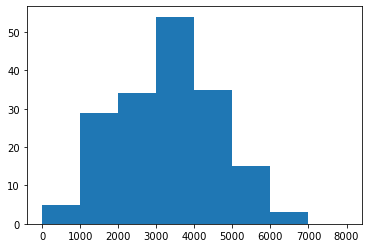

In [42]:
tr=pd.merge(tr,lungs_df.loc[:,dicom_feature],on='Patient')
plt.hist(lungs_df.Volume.values,bins=[0,1000,2000,3000,4000,5000,6000,7000,8000])

In [43]:
tr['WHERE'] = 'train'
chunk['WHERE'] = 'val'
sub['WHERE'] = 'test'
data = tr.append([chunk, sub])

In [44]:
data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

In [45]:
cut_labels_4 = [0, 1, 2, 3,4 ,5,6,7]
cut_bins = [0,1000,2000,3000,4000,5000,6000,7000,8000]
data['vol_bins']=-1
data['vol_bins']=pd.cut(data['Volume'], bins=cut_bins, labels=cut_labels_4)
#data['FVC_grade'] = pd.cut(data['FVC'], bins=cut_bins, labels=cut_labels_4)
#data['FVC_grade']=data.FVC_grade.values.astype('int')
data=data.fillna(0)
data['vol_bins']=data.vol_bins.values.astype('int')

In [46]:
data['follow_up_count']=0
data=data.sort_values(by=['Patient','Weeks'])
for patient in data.Patient.unique():
    data.loc[data.Patient==patient,'follow_up_count']=range(data[data.Patient==patient].index.size)

In [47]:
data['Age_bins']=-1
cut_labels_age = [0, 1, 2, 3 ,4 ]
cut_bins = [0, 30, 50, 60,70,100 ]
#data['FVC_grade'] = pd.cut(data['FVC'], bins=cut_bins, labels=cut_labels_4)
#data.loc[data.Sex=='Male','Age_bins']= pd.cut(data[data.Sex=='Male']['Age'], bins=cut_bins, labels=cut_labels_age)
data.loc[:,'Age_bins']= pd.cut(data['Age'], bins=cut_bins, labels=cut_labels_age)

data['Age_bins']=data['Age_bins'].astype('int')
data=data.fillna(0)

In [48]:
data['pct_bins']=-1
cut_labels_age = [0, 1, 2, 3 ,4 ,5]
cut_bins = [0, 30, 50, 60,70,100,180 ]
#data['FVC_grade'] = pd.cut(data['FVC'], bins=cut_bins, labels=cut_labels_4)
#data.loc[data.Sex=='Male','Age_bins']= pd.cut(data[data.Sex=='Male']['Age'], bins=cut_bins, labels=cut_labels_age)
data.loc[:,'pct_bins']= pd.cut(data['Percent'], bins=cut_bins, labels=cut_labels_age)
#data=data.fillna(0)
data['pct_bins']=data['pct_bins'].astype('int')
data=data.fillna(0)

In [49]:
percent_std=data.groupby('Age_bins').Percent.std().values 
percent_mean=data.groupby('Age_bins').Percent.mean().values

In [50]:
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC','Percent','pct_bins']].copy()
base.columns = ['Patient','min_FVC','min_Percent','min_pct_bin']
'''
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
'''
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)

In [51]:
data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']

In [52]:
data['diff_fvc_prev']=data['FVC'].diff(1)
data=data.fillna(0)
patient_mean_chg_df=data.groupby('Patient').diff_fvc_prev.mean().reset_index()
patient_mean_chg_df.columns=['Patient','mean_increase']
#data['mean_increase']=data.groupby('Patient').diff_fvc_prev.mean().values
data=pd.merge(data,patient_mean_chg_df ,on='Patient')

In [53]:
COLS = ['Sex','SmokingStatus'] #,'Age'
FE = []
for col in COLS:
    for mod in data[col].unique():
        FE.append(mod)
        data[mod] = (data[col] == mod).astype(int)

In [54]:
data_patient_percent_df=data.groupby('Patient').agg(percent= ('Percent',np.median),height_std= ('Percent',np.mean)).reset_index()
data_patient_percent_df.columns=['Patient','Median_percent','Mean_percent']
data=pd.merge(data,data_patient_percent_df.loc[:,['Patient','Median_percent']],on='Patient')

data_percent_group_mean_df=data.groupby(['Sex','Age_bins','SmokingStatus']).agg(group_pct_mean=('Median_percent',np.median)).reset_index()

data_percent_group_mean_df.columns=['Sex','Age_bins','SmokingStatus','group_pct_median']


data=pd.merge(data,data_percent_group_mean_df,on=['Sex','Age_bins','SmokingStatus'],how='left')


data['med_pct_bins']=-1
cut_labels_age = [0, 1, 2, 3 ,4 ,5]
cut_bins = [0, 30, 50, 60,70,100,180 ]
#data['FVC_grade'] = pd.cut(data['FVC'], bins=cut_bins, labels=cut_labels_4)
#data.loc[data.Sex=='Male','Age_bins']= pd.cut(data[data.Sex=='Male']['Age'], bins=cut_bins, labels=cut_labels_age)
data.loc[:,'med_pct_bins']= pd.cut(data['group_pct_median'], bins=cut_bins, labels=cut_labels_age)
#data=data.fillna(0)
data=data.fillna(0)
data['med_pct_bins']=data['med_pct_bins'].astype('int')

In [55]:
FE_hi=FE.copy()
FE_pyt=FE.copy()
FE_med=FE.copy()
FE_low=FE.copy()
data_pow=data.copy()

In [56]:
data=data.fillna(0)
data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
#data['percent'] = data['Percent']/100.
#data['percent']=(data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )
data['min_Percent_norm']=(data['min_Percent'] - data['min_Percent'].min() ) / ( data['min_Percent'].max() - data['min_Percent'].min() )
data['group_pct_median_norm']=(data['group_pct_median'] - data['group_pct_median'].min() ) / ( data['group_pct_median'].max() - data['group_pct_median'].min() )

data['Volume']=data['Volume']/1000.
data['Volume']=(data['Volume'] - data['Volume'].min()  ) / ( data['Volume'].max() - data['Volume'].min() )

data['Kurthosis']=(data['Kurthosis'] - data['Kurthosis'].min() ) / ( data['Kurthosis'].max() - data['Kurthosis'].min() )
data['Mean']=(data['Mean'] - data['Mean'].min() ) / ( data['Mean'].max() - data['Mean'].min() )
data['Skew']=(data['Skew'] - data['Skew'].min() ) / ( data['Skew'].max() - data['Skew'].min() )
 
#data['mean_increase']=(data['mean_increase'] - data['mean_increase'].min() ) / ( data['mean_increase'].max() 
#                                                                                - data['mean_increase'].min() )

'''
data['percent']=0.
data.loc[data.Age_bins==1,'percent'] = (data[data.Age_bins==1]['Percent'] - percent_mean[0] ) /percent_std[0] 
data.loc[data.Age_bins==2,'percent'] = (data[data.Age_bins==2]['Percent'] - percent_mean[1] ) /percent_std[1]  
data.loc[data.Age_bins==3,'percent'] = (data[data.Age_bins==3]['Percent'] - percent_mean[2] ) /percent_std[2]  
data.loc[data.Age_bins==4,'percent'] = (data[data.Age_bins==4]['Percent'] - percent_mean[3] ) /percent_std[3]  
#data['diff_fvc_prev']=data['FVC'].diff(1)
#data['follow_up_diff']=data['Weeks'].diff(1)
data=data.fillna(0)
'''
#data['diff_fvc_prev'] = (data['diff_fvc_prev'] - data['diff_fvc_prev'].min() ) / ( data['diff_fvc_prev'].max() - data['diff_fvc_prev'].min() )
#data['follow_up_diff'] = (data['follow_up_diff'] - data['follow_up_diff'].min() ) / ( data['follow_up_diff'].max() - data['follow_up_diff'].min() )
#data['follow_up_count']= (data['follow_up_count'] - data['follow_up_count'].min() ) / ( data['follow_up_count'].max())
#data['FVC_grade']= (data['FVC_grade'] - data['FVC_grade'].min() ) / ( data['FVC_grade'].max())
#
#data['normal']= (data['normal'] - data['normal'].min() ) / ( data['normal'].max())

#data['max_fvc']=(data['max_fvc'] - data['max_fvc'].min() ) / ( data['max_fvc'].max()) ,'min_Percent','min_pct_bin'
FE_med+=['Age_bins','min_pct_bin','min_Percent','week','BASE' ,'Volume','Skew' ]
FE_low+=['Age_bins','min_Percent','week','BASE' ]
FE_pyt +=  ['Age_bins','med_pct_bins','min_pct_bin','group_pct_median','base_week','min_Percent','min_FVC' ,'Volume','Skew' ]

#['Age_bins','group_pct_median_norm','min_pct_bin','med_pct_bins','min_Percent_norm','week','BASE' ,'Volume','Skew' ]
#['Age_bins','pct_bins','min_Percent','week','BASE' ,'Volume','Skew' ]

In [57]:
#data.rename_columns({'base_week':'diff_from'})
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
powerTransformer = PowerTransformer()
#X_train_scaled = powerTransformer.fit_transform(X_train) 
manual=False
if not manual:
    
    scaler_train=PowerTransformer()
    scaler_train_Fvc=PowerTransformer()
    #MinMaxScaler()
    data_pow['Volume']=data_pow['Volume']/1000.
    data_pow.loc[:,['min_Percent', 'group_pct_median'  , 'min_FVC','base_week','Mean','Skew','Volume']]=   scaler_train.fit_transform(data_pow[['min_Percent','group_pct_median' , 'min_FVC','base_week','Mean','Skew','Volume']])
    #sub.loc[:,['Percent',  'min_FVC','base_week','Mean','Skew','Volume']]=  scaler_train.fit_transform(sub[['Percent',  'min_FVC','base_week','Mean','Skew','Volume']])
    data_pow.loc[:,'FVC']= scaler_train_Fvc.fit_transform(data_pow.loc[:,'FVC'].values.reshape(-1,1))
    #data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
    #sub['week'] = (sub['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
    
    #FE=FE+['Age_bins','pct_bins','min_Percent','min_FVC', 'base_week','Skew','Volume']
    #FE +=  ['Age_bins','med_pct_bins','min_pct_bin','group_pct_median','base_week','min_Percent','min_FVC' ,'Volume','Skew' ]
    
    FE_hi +=  ['Age_bins','med_pct_bins','min_pct_bin','group_pct_median','base_week','min_Percent','min_FVC' ,'Volume','Skew' ]

    print(len(FE) ) 

5


/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


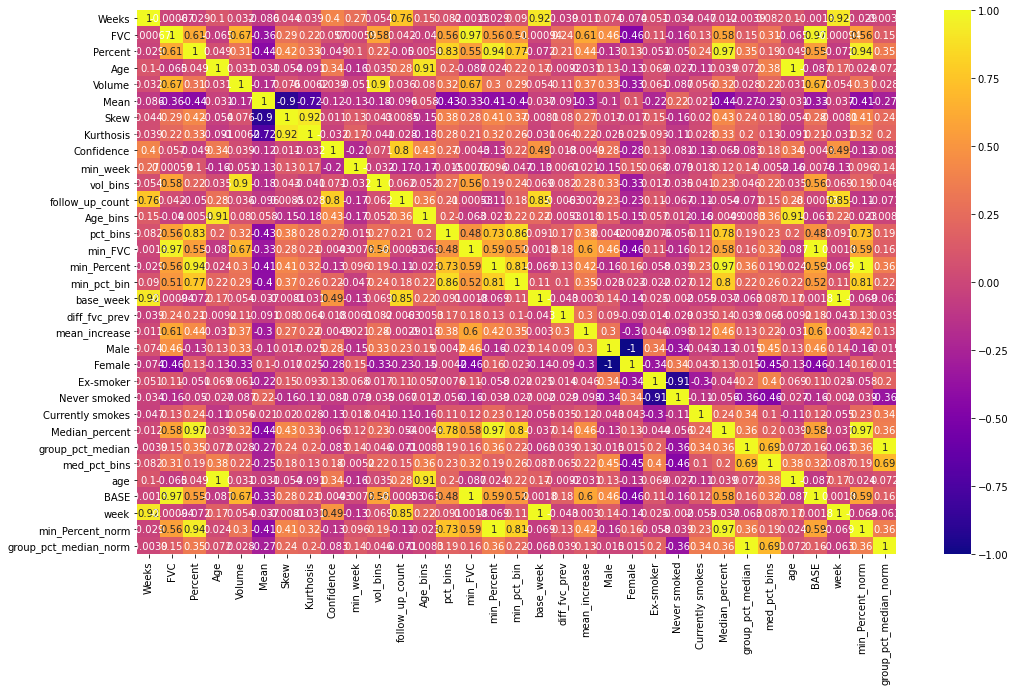

In [58]:
import seaborn as sns
plt.figure(figsize=(17,10))
sns.heatmap(data.corr(), annot=True, cmap=plt.cm.plasma)

In [59]:
data.columns

Index(['Patient', 'Weeks', 'FVC', 'Percent', 'Age', 'Sex', 'SmokingStatus',
       'Volume', 'Mean', 'Skew', 'Kurthosis', 'WHERE', 'Confidence',
       'Patient_Week', 'min_week', 'vol_bins', 'follow_up_count', 'Age_bins',
       'pct_bins', 'min_FVC', 'min_Percent', 'min_pct_bin', 'base_week',
       'diff_fvc_prev', 'mean_increase', 'Male', 'Female', 'Ex-smoker',
       'Never smoked', 'Currently smokes', 'Median_percent',
       'group_pct_median', 'med_pct_bins', 'age', 'BASE', 'week',
       'min_Percent_norm', 'group_pct_median_norm'],
      dtype='object')

In [60]:
tr = data.loc[data.WHERE=='train']
tr_pow=data_pow.loc[data.WHERE=='train']
chunk = data.loc[data.WHERE=='val']
sub = data.loc[data.WHERE=='test'] #joined with chunk above
sub_hi=data_pow.loc[data.WHERE=='test']
#del data

In [61]:
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(800, dtype="float32")
#=============================#
def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    #print(delta,C2,C1)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)

def smooth_L1_loss(y_true, y_pred):
    h = tf.keras.losses.Huber(delta=100.)
    return h(y_true, y_pred)

def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    #qs = [np.random.uniform(0.06,0.2), np.random.uniform(0.35,0.5), np.random.uniform(0.7,0.8)]
    qs = [0.2 , 0.5 , 0.8 ]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    q800 = tf.constant(np.array([800.]), dtype=tf.float32)
    e = y_true - y_pred
    #smooth_L1_loss(y_true,y_pred)
    #y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)#+0.2*tf.maximum(q800,e)
    return K.mean(v)
#=============================#
def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss
#=================
def make_model(nh):
    z = L.Input((nh,), name="Patient")
    x = L.Dense(100, activation="relu", name="d1")(z)
    #x=L.MaxPool1D()(x)
    #x = L.Dense(50, activation="relu", name="d2")(x)
    #x=L.MaxPool1D()(x)
    x = L.Dense(100, activation="relu", name="d3")(x)
    
    ''' 
    batch_size=K.shape(x)[0]
    #print(x.shape,batch_size)
    x=K.reshape(x,(batch_size,100,1)) 
    #print(x.shape)
    x1=L.MaxPool1D( )(x)
    x2=L.AvgPool1D( )( x)
    print(x2.shape,x1.shape)
    x1=K.reshape(x1,(batch_size,50))   
    x2=K.reshape(x2,(batch_size,50)) 
    x=K.concatenate([x1,x2],axis=1)
    x=K.reshape(x,(batch_size,100)) 
    #print(x.shape)               
    #x = L.Dense(100, activation="relu", name="d3")(x)
    '''
    p1 = L.Dense(3, activation="linear", name="p1")(x)
    p2 = L.Dense(3, activation="relu", name="p2")(x)
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    model = M.Model(z, preds, name="CNN")
    #model.compile(loss=qloss, optimizer="adam", metrics=[score])
    model.compile(loss=mloss(0.6), optimizer=tf.keras.optimizers.Adam(lr=8e-2, beta_1=0.9, beta_2=0.999, 
                                                                      epsilon=None, decay=0.01, amsgrad=False), 
                  metrics=[score])
    return model

In [62]:
y_low = tr['FVC'].values.astype(np.float)
z_low = tr[FE_low].values
ze_low = sub[FE_low].values
nh1 = z_low.shape[1]

y_hi = tr_pow['FVC'].values.astype(np.float)
z_hi = tr_pow[FE_hi].values
ze_hi = sub_hi[FE_hi].values
nh2 = z_hi.shape[1] 

y_pyt = tr['FVC'].values.astype(np.float)
z_pyt = tr[FE_pyt].values
ze_pyt = sub[FE_pyt].values
 

y_med = tr['FVC'].values.astype(np.float)
z_med = tr[FE_med].values
ze_med = sub[FE_med].values
nh3 = z_med.shape[1] 

In [63]:
NFOLD = 5
kf = KFold(n_splits=NFOLD)

In [64]:
%%time
cnt = 0
EPOCHS =800


from keras.callbacks import EarlyStopping,ModelCheckpoint
#earlyStopping =  EarlyStopping(monitor='val_loss', patience=100, verbose=0, mode='min')
pred_rounds=[]
for r in range(1):
    #NFOLD=0
    pe_low = np.zeros((ze_low.shape[0], 3))
    pred_low = np.zeros((z_low.shape[0], 3))
    
    for tr_idx, val_idx in kf.split(z_low):
        #checkpoint = ModelCheckpoint('{cnt}_bestmodel.pth', monitor='val_loss', verbose=1, save_best_only=True, 
        #                         mode='auto')

        cnt += 1
        #filepath=f'{cnt}_bestmodel.hdf5'
        #checkpoint = ModelCheckpoint(filepath, monitor='val_score', verbose=0, save_best_only=True, mode='min')
        print(f"FOLD {cnt}")

        tr_arry=z_low[tr_idx]
        val=z_low[val_idx]
        y_tr=y_low[tr_idx]
        y_val=y_low[val_idx]
        net = make_model(nh1)
        net.fit(tr_arry, y_tr, batch_size=BATCH_SIZE, epochs=EPOCHS, #callbacks=[checkpoint],

                validation_data=(val, y_val), verbose=0) #
        print("train", net.evaluate(tr_arry, y_tr, verbose=0, batch_size=BATCH_SIZE))
        print("val", net.evaluate(val, y_val, verbose=0, batch_size=BATCH_SIZE))
        print("predict val...")
        #net.load_model('/kaggle/working/'+f'{cnt}_bestmodel.pth')
        #net.load_weights(filepath)
        pred_low[val_idx] = net.predict(val, batch_size=BATCH_SIZE, verbose=0)
        print("predict test...",NFOLD)
        pe_low += net.predict(ze_low, batch_size=BATCH_SIZE, verbose=0) / NFOLD
    #pred_rounds.append(pe)
#==============

FOLD 1
train [39.48667526245117, 6.691788673400879]
val [44.24418640136719, 6.858059406280518]
predict val...
predict test... 5
FOLD 2
train [39.7991943359375, 6.688143253326416]
val [38.23630142211914, 6.655994415283203]
predict val...
predict test... 5
FOLD 3
train [35.642333984375, 6.552924156188965]
val [53.22988510131836, 6.889411926269531]
predict val...
predict test... 5
FOLD 4
train [40.84168243408203, 6.71117639541626]
val [33.873390197753906, 6.556999683380127]
predict val...
predict test... 5
FOLD 5
train [39.25, 6.659409523010254]
val [39.937129974365234, 6.7261176109313965]
predict val...
predict test... 5
CPU times: user 4min 45s, sys: 22.2 s, total: 5min 8s
Wall time: 4min 16s


In [65]:
%%time
cnt = 0
EPOCHS =800


from keras.callbacks import EarlyStopping,ModelCheckpoint
#earlyStopping =  EarlyStopping(monitor='val_loss', patience=100, verbose=0, mode='min')
pred_rounds=[]
for r in range(1):
    #NFOLD=0
    pe_med = np.zeros((ze_med.shape[0], 3))
    pred_med = np.zeros((z_med.shape[0], 3))
    
    for tr_idx, val_idx in kf.split(z_med):
        #checkpoint = ModelCheckpoint('{cnt}_bestmodel.pth', monitor='val_loss', verbose=1, save_best_only=True, 
        #                         mode='auto')

        cnt += 1
        #filepath=f'{cnt}_bestmodel.hdf5'
        #checkpoint = ModelCheckpoint(filepath, monitor='val_score', verbose=0, save_best_only=True, mode='min')
        print(f"FOLD {cnt}")

        tr_arry=z_med[tr_idx]
        val=z_med[val_idx]
        y_tr=y_med[tr_idx]
        y_val=y_med[val_idx]
        net = make_model(nh3)
        net.fit(tr_arry, y_tr, batch_size=BATCH_SIZE, epochs=EPOCHS, #callbacks=[checkpoint],

                validation_data=(val, y_val), verbose=0) #
        print("train", net.evaluate(tr_arry, y_tr, verbose=0, batch_size=BATCH_SIZE))
        print("val", net.evaluate(val, y_val, verbose=0, batch_size=BATCH_SIZE))
        print("predict val...")
        #net.load_model('/kaggle/working/'+f'{cnt}_bestmodel.pth')
        #net.load_weights(filepath)
        pred_med[val_idx] = net.predict(val, batch_size=BATCH_SIZE, verbose=0)
        print("predict test...",NFOLD)
        pe_med+= net.predict(ze_med, batch_size=BATCH_SIZE, verbose=0) / NFOLD
    #pred_rounds.append(pe)
#==============

FOLD 1
train [38.76130676269531, 6.689312934875488]
val [42.3601188659668, 6.829736709594727]
predict val...
predict test... 5
FOLD 2
train [38.77976989746094, 6.672355651855469]
val [38.127288818359375, 6.654741287231445]
predict val...
predict test... 5
FOLD 3
train [35.6963005065918, 6.572758674621582]
val [51.97804641723633, 6.8511061668396]
predict val...
predict test... 5
FOLD 4
train [39.53409194946289, 6.714964389801025]
val [36.27939224243164, 6.630760192871094]
predict val...
predict test... 5
FOLD 5
train [38.485225677490234, 6.646700859069824]
val [39.0633659362793, 6.722283840179443]
predict val...
predict test... 5
CPU times: user 4min 49s, sys: 21.8 s, total: 5min 11s
Wall time: 4min 18s


In [66]:
%%time
cnt = 0
EPOCHS =800


from keras.callbacks import EarlyStopping,ModelCheckpoint
#earlyStopping =  EarlyStopping(monitor='val_loss', patience=100, verbose=0, mode='min')
pred_rounds=[]
for r in range(1):
    #NFOLD=0
    pe_hi = np.zeros((ze_hi.shape[0], 3))
    pred_hi = np.zeros((z_hi.shape[0], 3))
    
    for tr_idx, val_idx in kf.split(z_hi):
        #checkpoint = ModelCheckpoint('{cnt}_bestmodel.pth', monitor='val_loss', verbose=1, save_best_only=True, 
        #                         mode='auto')

        cnt += 1
        #filepath=f'{cnt}_bestmodel.hdf5'
        #checkpoint = ModelCheckpoint(filepath, monitor='val_score', verbose=0, save_best_only=True, mode='min')
        print(f"FOLD {cnt}")

        tr_arry=z_hi[tr_idx]
        val=z_hi[val_idx]
        y_tr=y_hi[tr_idx]
        y_val=y_hi[val_idx]
        net = make_model(nh2)
        net.fit(tr_arry, y_tr, batch_size=BATCH_SIZE, epochs=EPOCHS, #callbacks=[checkpoint],

                validation_data=(val, y_val), verbose=0) #
        print("train", net.evaluate(tr_arry, y_tr, verbose=0, batch_size=BATCH_SIZE))
        print("val", net.evaluate(val, y_val, verbose=0, batch_size=BATCH_SIZE))
        print("predict val...")
        #net.load_model('/kaggle/working/'+f'{cnt}_bestmodel.pth')
        #net.load_weights(filepath)
        pred_hi[val_idx] = net.predict(val, batch_size=BATCH_SIZE, verbose=0)
        print("predict test...",NFOLD)
        pe_hi += net.predict(ze_hi, batch_size=BATCH_SIZE, verbose=0) / NFOLD
    #pred_rounds.append(pe)
#==============

FOLD 1
train [1.8866376876831055, 4.598831653594971]
val [1.8924391269683838, 4.599450588226318]
predict val...
predict test... 5
FOLD 2
train [1.8793745040893555, 4.598298072814941]
val [1.901677131652832, 4.599924564361572]
predict val...
predict test... 5
FOLD 3
train [1.8797193765640259, 4.598349571228027]
val [1.9268357753753662, 4.601089954376221]
predict val...
predict test... 5
FOLD 4
train [1.8873720169067383, 4.59890079498291]
val [1.8889422416687012, 4.598948001861572]
predict val...
predict test... 5
FOLD 5
train [1.8855596780776978, 4.598734378814697]
val [1.9025477170944214, 4.599823951721191]
predict val...
predict test... 5
CPU times: user 4min 45s, sys: 21.5 s, total: 5min 7s
Wall time: 4min 15s


In [67]:
sigma_opt = mean_absolute_error(y_low, pred_low[:, 1])
unc = pred_low[:,2] - pred_low[:, 0]
sigma_mean = np.mean(unc)
print(sigma_opt, sigma_mean)

sigma_opt = mean_absolute_error(y_hi, pred_hi[:, 1])
unc = pred_hi[:,2] - pred_hi[:, 0]
sigma_mean = np.mean(unc)
print(sigma_opt, sigma_mean)


sigma_opt = mean_absolute_error(y_med, pred_med[:, 1])
unc = pred_med[:,2] - pred_med[:, 0]
sigma_mean = np.mean(unc)
print(sigma_opt, sigma_mean)

153.44435239909913 255.24709838469565
0.24023926235793244 0.3023938111014397
153.40584339054865 260.30063635611765


In [68]:
print(unc.min(), unc.mean(), unc.max(), (unc>=0).mean())

157.93603515625 260.30063635611765 398.328369140625 1.0


In [69]:
sub_hi['FVC1'] =scaler_train_Fvc.inverse_transform((pe_hi[:, 1] ).reshape(-1,1))
pe2=scaler_train_Fvc.inverse_transform((pe_hi[:, 2] ).reshape(-1,1))
pe1=scaler_train_Fvc.inverse_transform((pe_hi[:,0]).reshape(-1,1))
                                       
sub_hi['Confidence1'] =  pe2-pe1



sub['FVC1']=pe_low[:, 1]*0.5+ pe_med[:, 1]*0.5
sub['Confidence1'] = (pe_low[:, 2] - pe_low[:, 0])*0.5 +(pe_med[:, 2] - pe_med[:, 0])*0.5  #*1.05

 
#sub['FVC1'] = 0.996*pred[:, 1]
#sub['Confidence1'] = pred[:, 2] - pred[:, 0]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [70]:
subm = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()
subm_hi = sub_hi[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()

In [71]:
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']

subm['Confidence1'] =subm.Confidence1.apply(lambda x: 70. if x <70 else x)
subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']

In [72]:
subm_hi.loc[~subm_hi.FVC1.isnull(),'FVC'] = subm_hi.loc[~subm_hi.FVC1.isnull(),'FVC1']
subm_hi['Confidence1'] =subm_hi.Confidence1.apply(lambda x: 70. if x <70 else x)
subm_hi.loc[~subm_hi.FVC1.isnull(),'Confidence'] = subm_hi.loc[~subm_hi.FVC1.isnull(),'Confidence1']

In [73]:
def laplace_log_likelihood_oof(df, pred_col,
                               confidence_col,
                               return_values = False):
    """
    Calculates the modified Laplace Log Likelihood score for this competition.
    """
    df = df.copy()
    df['Patient_Week'] = df['Patient'] + '_' + df['Weeks'].astype('str')
    df = df.loc[df['Patient_Week'].isin(final3)]
    actual_fvc = df['FVC']
    predicted_fvc = df[pred_col]
    confidence=df[confidence_col]  
    sd_clipped = np.maximum(confidence, 70)
    delta = np.minimum(np.abs(actual_fvc - predicted_fvc), 1000)
    metric = - np.sqrt(2) * delta / sd_clipped - np.log(np.sqrt(2) * sd_clipped)

    if return_values:
        return metric
    else:
        return np.mean(metric)

In [74]:
oof_df = tr[['Patient','Weeks','FVC']].copy()
oof_df['FVC1'] = pred_low[:, 1]*0.5+ pred_med[:, 1]*0.5
oof_df['Confidence1'] = (pred_low[:, 2] - pred_low[:, 0])*0.5 +(pred_med[:, 2] - pred_med[:, 0])*0.5  #*1.05

In [75]:
otest = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
for i in range(len(otest)):
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'FVC'] = otest.FVC[i]
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'Confidence'] = 0.1

In [76]:
otest = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
for i in range(len(otest)):
    subm_hi.loc[subm_hi['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'FVC'] = otest.FVC[i]
    subm_hi.loc[subm_hi['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'Confidence'] = 0.1

In [77]:
final3 = (tr.groupby('Patient').tail(3)['Patient'] + '_' + tr.groupby('Patient').tail(3)['Weeks'].astype('str')).values

In [78]:
oof_score1 = laplace_log_likelihood_oof(oof_df, 'FVC1','Confidence1')
print(f'OOF Score 1: {oof_score1:0.5f}')

OOF Score 1: -7.00124


In [79]:
df4

NameError: name 'df4' is not defined

In [80]:
df4 = pd.merge(subm[['Patient_Week','FVC','Confidence']],subm_hi[['Patient_Week','FVC','Confidence']],on='Patient_Week')
df4['Confidence'] = (2*df4['Confidence_x'] + df4['Confidence_y'])/3.0
df4['FVC'] = (2*df4['FVC_x'] + df4['FVC_y'])/3.0
df4 = df4[['Patient_Week','FVC','Confidence']]
df4.to_csv('submission4.csv', index=False)
df4.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3139.981531,229.893470
1,ID00419637202311204720264_-11,3135.120998,230.183826
2,ID00419637202311204720264_-10,3129.394508,230.945739
3,ID00419637202311204720264_-9,3124.540161,234.724408
4,ID00419637202311204720264_-8,3117.400257,235.829856


In [81]:
tmp = pd.merge(df2[['Patient_Week','FVC','Confidence']],df4[['Patient_Week','FVC','Confidence']],on='Patient_Week')
tmp['Confidence'] = 0.65*tmp['Confidence_x'] + 0.35*tmp['Confidence_y']
tmp['FVC'] = 0.65*tmp['FVC_x'] + 0.35*tmp['FVC_y']
tmp = tmp[['Patient_Week','FVC','Confidence']]
tmp.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3050.260211,261.321882
1,ID00419637202311204720264_-11,3046.188174,261.804207
2,ID00419637202311204720264_-10,3041.816386,262.454275
3,ID00419637202311204720264_-9,3037.739056,264.161477
4,ID00419637202311204720264_-8,3032.861306,264.937971


In [82]:
#df = pd.merge(pd.merge(df1,df2,on='Patient_Week'),df3,on='Patient_Week')
df = pd.merge(pd.merge(df1,tmp,on='Patient_Week'),df3,on='Patient_Week')
df['FVC'] = (df['FVC_x'] + df['FVC_y'] + df['FVC'])/3.0
df['Confidence'] = (df['Confidence_x'] + df['Confidence_y'] + df['Confidence'])/3.0
df[['Patient_Week','FVC','Confidence']].to_csv('submission.csv', index=False)
df.head()

,Patient_Week,FVC_x,Confidence_x,FVC_y,Confidence_y,FVC,Confidence
0,ID00419637202311204720264_-12,2951.215576,367.666565,3050.260211,261.321882,3006.284762,288.977474
1,ID00419637202311204720264_-11,2949.578125,367.859619,3046.188174,261.804207,3003.298736,289.198940
2,ID00419637202311204720264_-10,2947.940918,368.052734,3041.816386,262.454275,3000.212874,289.476561
3,ID00419637202311204720264_-9,2946.303467,368.245941,3037.739056,264.161477,2997.225084,290.106810
4,ID00419637202311204720264_-8,2944.666016,368.439362,3032.861306,264.937971,2993.970487,290.427116
